In [51]:
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np
from matplotlib import pyplot as plt
from pandas import DataFrame
from scipy.stats import mannwhitneyu

In [52]:
data = pd.read_csv("kickstarter_data.csv")
data['success_rate'] = data['pled'] / data['goal'] * 100
data.columns, data.shape

(Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
        'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
        'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
        'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
        'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
        'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
        'success_rate'],
       dtype='object'), (8421, 39))

In [53]:
data[data['goal'] < 5]['success_rate'].mean()

331540.3557309402

In [54]:
df = data
if 'Unnamed: 0' in df.columns or 'succsess' in df.columns:
    df = data.drop(columns=['Unnamed: 0', 'succsess'])
df.shape

(8421, 37)

In [55]:
df.isnull().sum()

URL                0
pled               0
goal               0
date               0
period             0
status             0
text_am            0
n_img              0
n_vid              0
n_pled_t           0
min_pled_t         0
max_pled_t         0
mean_pled_t        0
step_pled_t        0
cr_time            0
backed             0
created            0
site            2471
rpg                0
platformer         0
shooter            0
fighting           0
survival           0
horror             0
strategy           0
arcade             0
simulator          0
mmo                0
indie              0
action             0
quest              0
adventure          0
mgp                0
cont               0
curr               0
is_site            0
success_rate       0
dtype: int64

In [56]:
numeric_columns = ['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
futures = ['text_am', 'n_img', 'n_vid', 'created', 'cont', 'mgp', 'n_pled_t']
target_column = 'success_rate'
numeric_columns, target_column

(['pled',
  'goal',
  'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont'],
 'success_rate')

In [57]:
def draw_boxplots(df, numeric_columns):
    fig, axes = plt.subplots(4, 4, figsize=(18, 40))
    for i in range(2):
        for j in range(4):
            if 4 * i + j == len(numeric_columns):
                return
            axes[i, j].boxplot(df[numeric_columns[4 * i + j]], labels=[numeric_columns[4 * i + j]]) 

In [58]:
def draw_hist(df, features, bar_type=None,names_dict=None):
    bar_type = 'bar' if bar_type == None else bar_type
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            axes[i, j].hist(df[features[4 * i + j]], histtype=bar_type, bins=10)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Количество проектов с таким {features[4 * i + j]}', size=14)

In [59]:
def draw_hist_2(df, features, bar_type=None,names_dict=None):
    bar_type = 'bar' if bar_type == None else bar_type
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    rows = 7
    
    for i in range(rows):
        if i == len(features):
            return
        fig = plt.figure(figsize=(10, 8))
        plt.hist(df[features[i]], histtype=bar_type, bins=10)
        fig.xlabel = f'Значение переменной {features[i]}'
        fig.ylabel = f'Количество проектов с таким {features[i]}'

(8103, 39)

<Figure size 432x288 with 0 Axes>

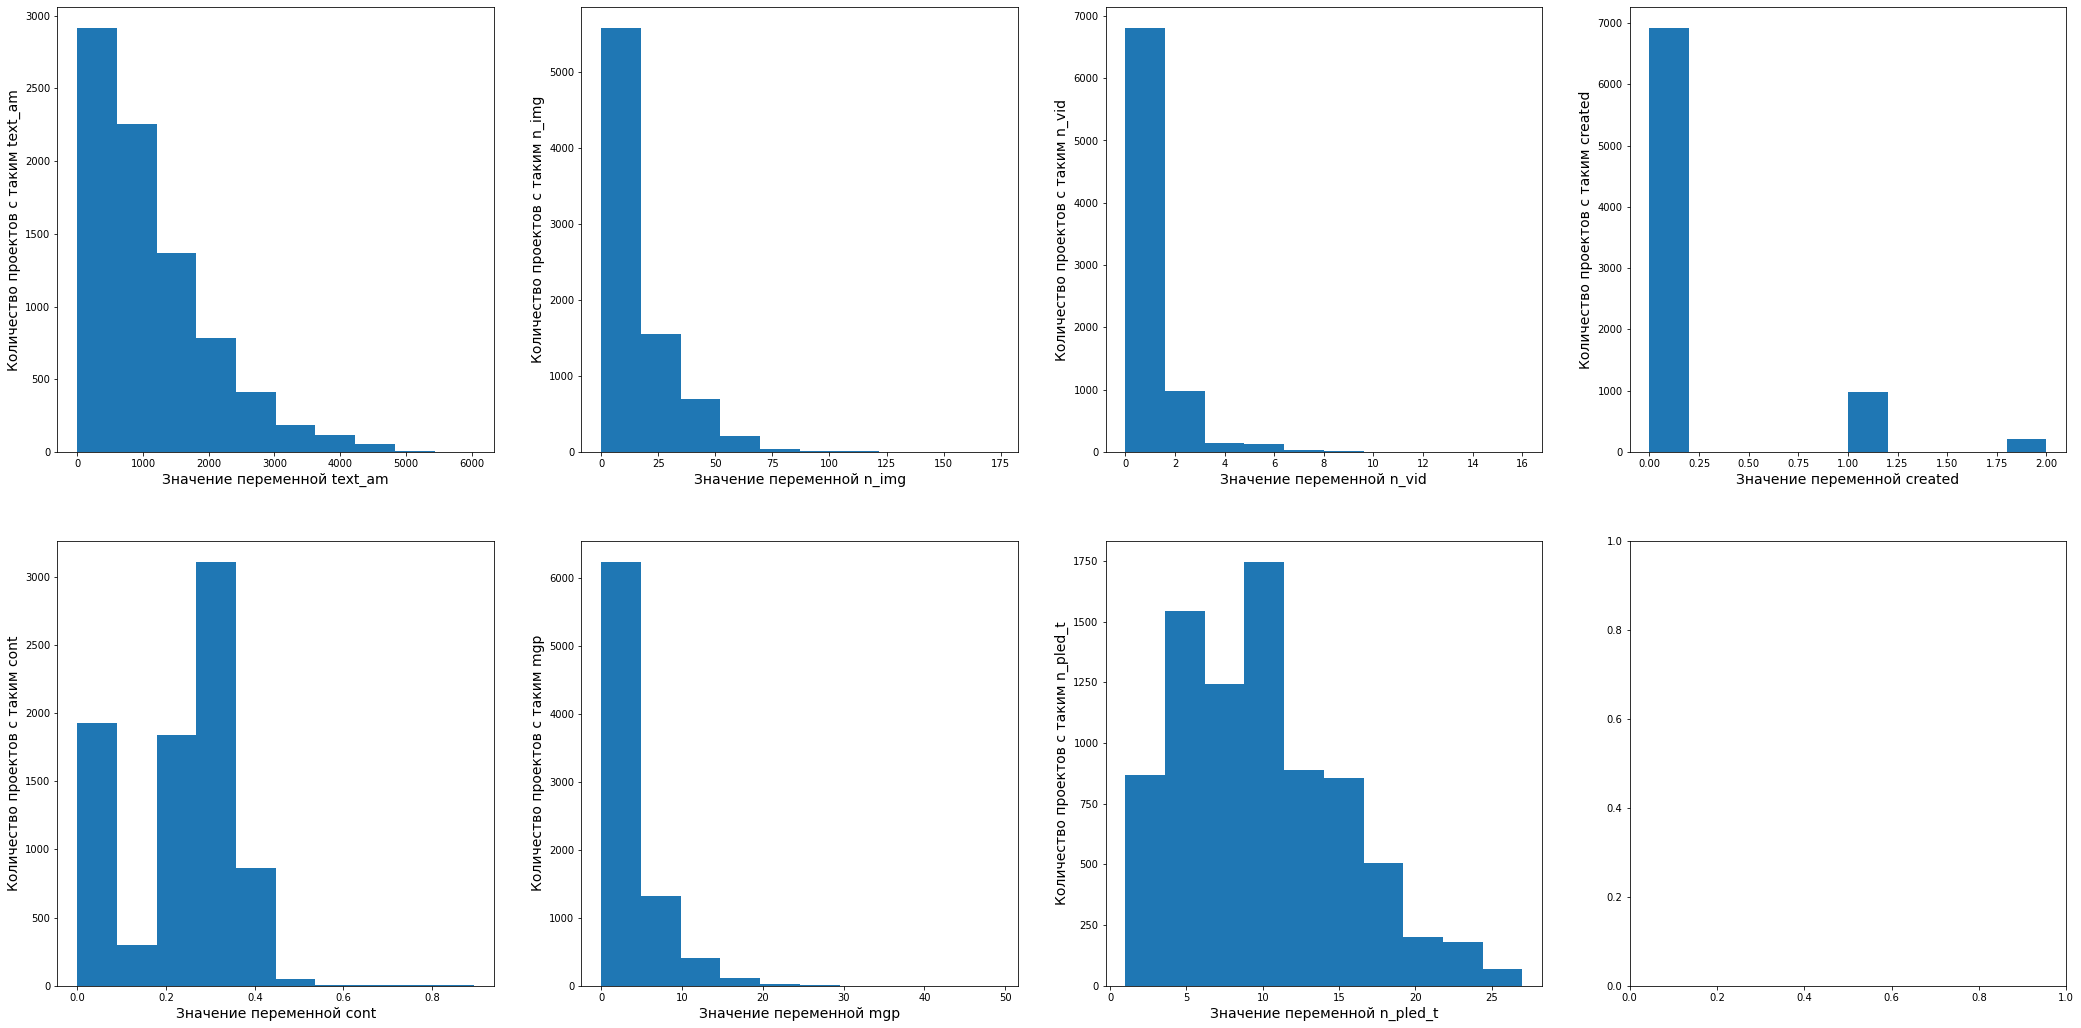

In [60]:
# Remove emissions
df = data
df = df[df['goal'] > 5]
df = df[df['period'] < 80]

df['site'].fillna('', inplace=True)

# Using 3 sigmas rule
n_sigmas = 3

std = df['created'].std() # Taken from description
mean = df['created'].mean()
df = df[(df['created'] >= mean - std * n_sigmas) & (df['created'] <= mean + std * n_sigmas)]

std = df['n_pled_t'].std() # Taken from description
mean = df['n_pled_t'].mean()
df = df[(df['n_pled_t'] >= mean - std * n_sigmas) & (df['n_pled_t'] <= mean + std * n_sigmas)]


draw_hist(df, futures, 'bar')
df.shape

In [61]:
df.isna().sum()

Unnamed: 0      0
URL             0
pled            0
goal            0
date            0
period          0
status          0
text_am         0
n_img           0
n_vid           0
n_pled_t        0
min_pled_t      0
max_pled_t      0
mean_pled_t     0
step_pled_t     0
cr_time         0
backed          0
created         0
site            0
rpg             0
platformer      0
shooter         0
fighting        0
survival        0
horror          0
strategy        0
arcade          0
simulator       0
mmo             0
indie           0
action          0
quest           0
adventure       0
mgp             0
cont            0
curr            0
succsess        0
is_site         0
success_rate    0
dtype: int64

In [62]:
# Descriptive statistics
desc = df[futures].describe()
desc.append(pd.Series(df[futures].median(), index=futures, name='median'))
desc

,text_am,n_img,n_vid,created,cont,mgp,n_pled_t
count,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000,8103.000000
mean,1120.421449,14.080464,0.727879,0.174010,0.223317,3.133268,9.789831
std,907.181807,16.347571,1.300123,0.444757,0.138091,3.915576,5.299370
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,416.000000,1.000000,0.000000,0.000000,0.141170,0.189363,6.000000
50%,874.000000,8.000000,0.000000,0.000000,0.267806,1.734000,9.000000
75%,1577.000000,22.000000,1.000000,0.000000,0.321677,4.591779,13.000000
max,6042.000000,174.000000,16.000000,2.000000,0.894847,49.141376,27.000000


In [63]:
pd.DataFrame(df.corr()['success_rate'][futures])

,success_rate
text_am,0.022853
n_img,0.035806
n_vid,0.052602
created,0.021287
cont,0.030704
mgp,0.043453
n_pled_t,0.013151


In [64]:
def draw_dependencies(df, features):
    rows = 2
    cols = 4
    plt.subplots_adjust(wspace=0.6, hspace=0.3)
    fig, axes = plt.subplots(rows, cols, figsize=(36, 18))
    for i in range(rows):
        for j in range(cols):
            if cols * i + j == len(features):
                return
            
            col = features[cols * i + j]
            xs = []
            ys = []

            if col == 'text_am':
                n_texts = []
                step = 200
                for v in range(1, df['text_am'].max(), step):
                    s = df[(df['text_am'] >= v) & (df['text_am'] < v + step)]['success_rate']
                    if s.shape[0] > 5: 
                        n_texts.append((f'{int((2 * v + step) / 2)}', v, s.sum() / s.shape[0]))

                n_texts = sorted(n_texts, key=lambda x: x[1])

                xs = [k for title, k, v in n_texts]
                ys = [v for title, k, v in n_texts]
            else:
                for val in sorted(df[col].unique()):
                    mean_sr = df[df[col] == val]['success_rate'].mean()
                    if df[df[col] == val].shape[0] > 5:
                        xs.append(val)
                        ys.append(mean_sr)

            axes[i, j].plot(xs, ys)
            axes[i, j].set_xlabel(f'Значение переменной {features[4 * i + j]}', size=14)
            axes[i, j].set_ylabel(f'Значение переменной success_rate', size=14)

<Figure size 432x288 with 0 Axes>

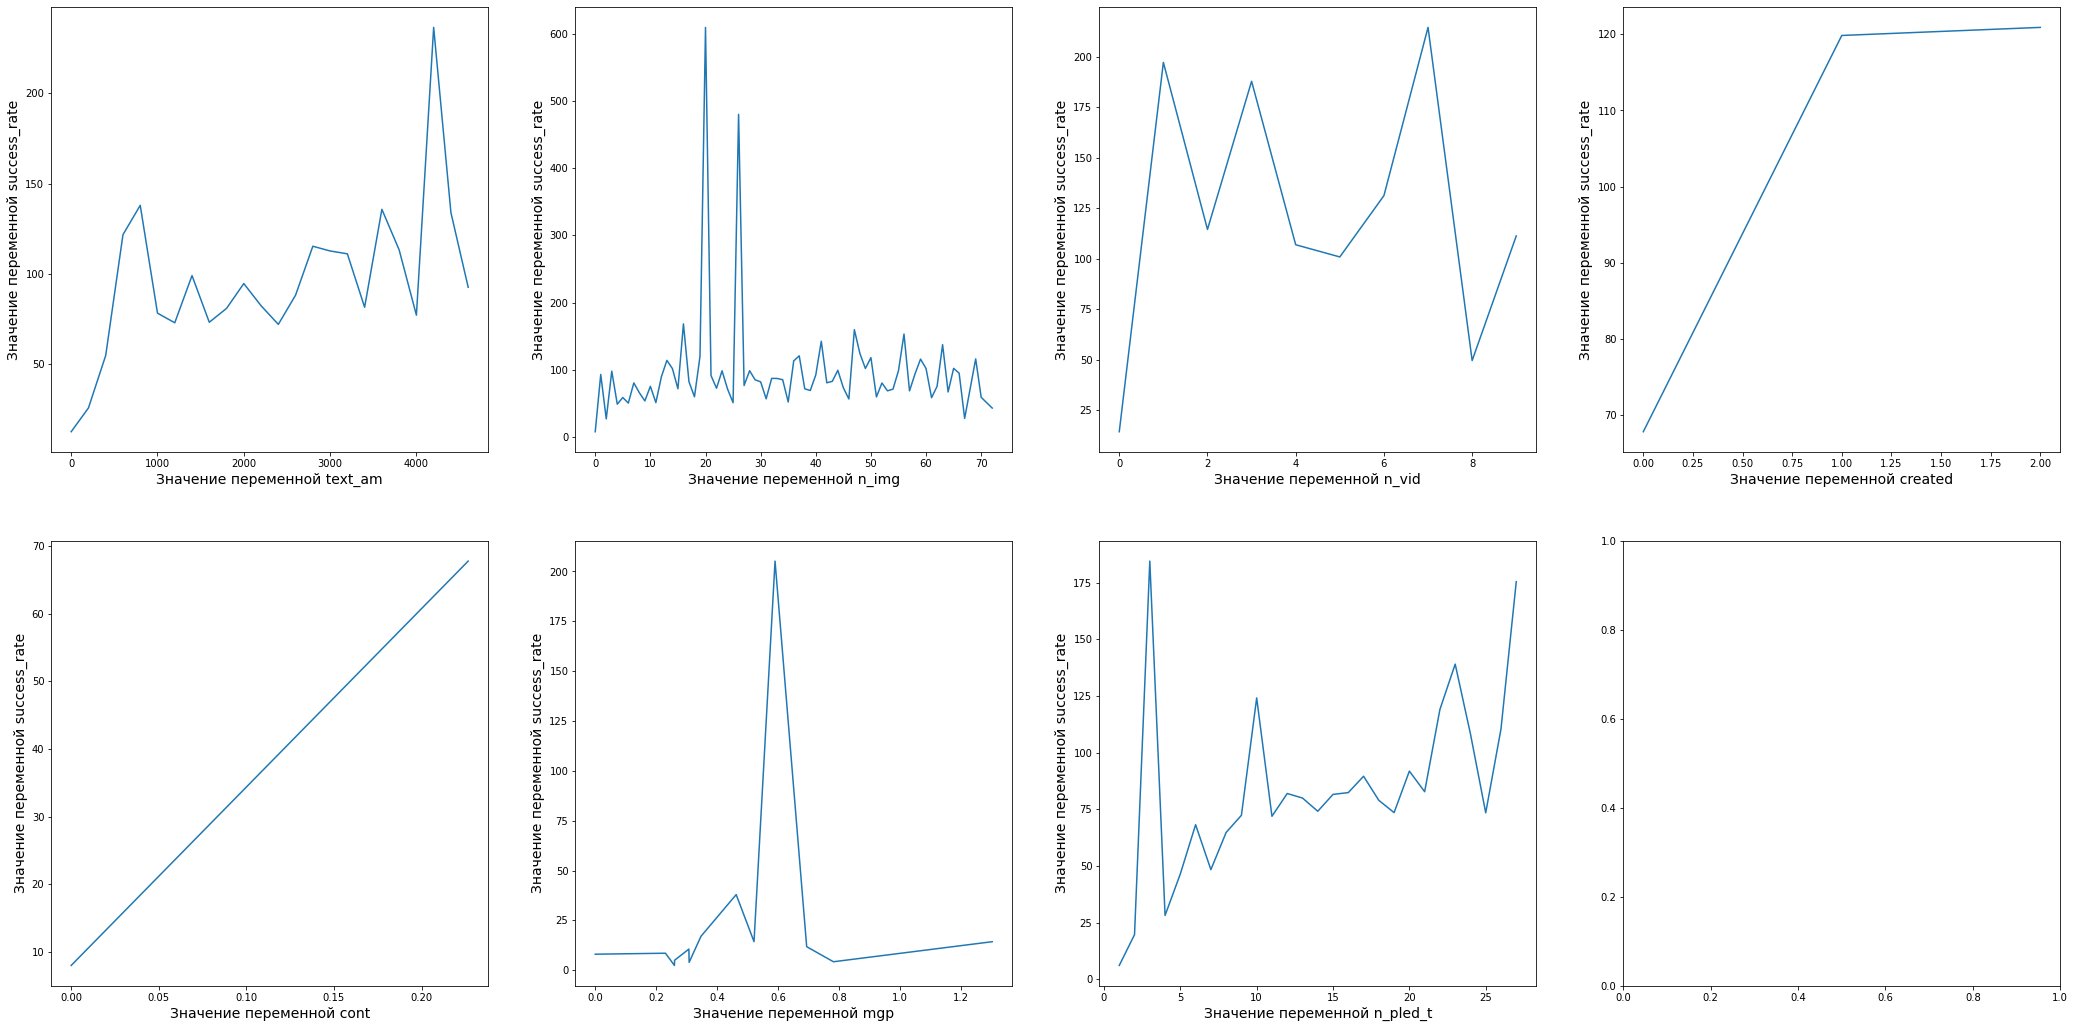

In [65]:
draw_dependencies(df, futures)

text_am 1.0 0.0
n_img 1.0 0.0
n_vid 1.0 0.0
mgp 1.0 0.0
n_pled_t 1.0 0.0


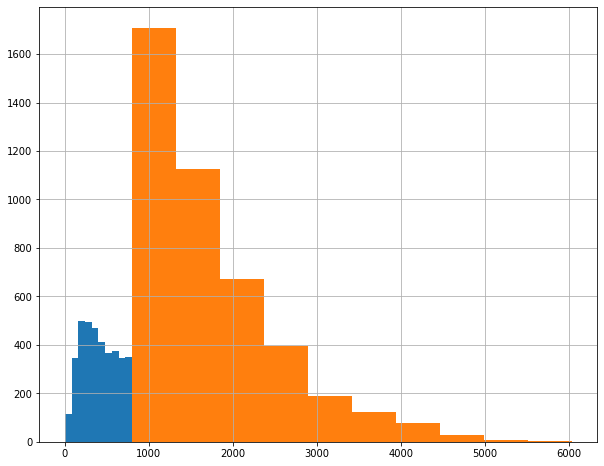

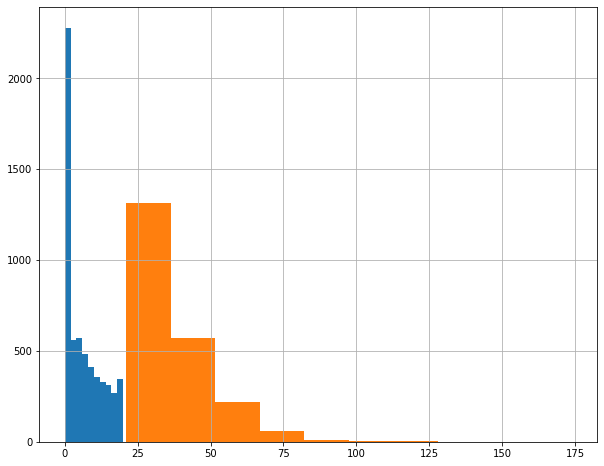

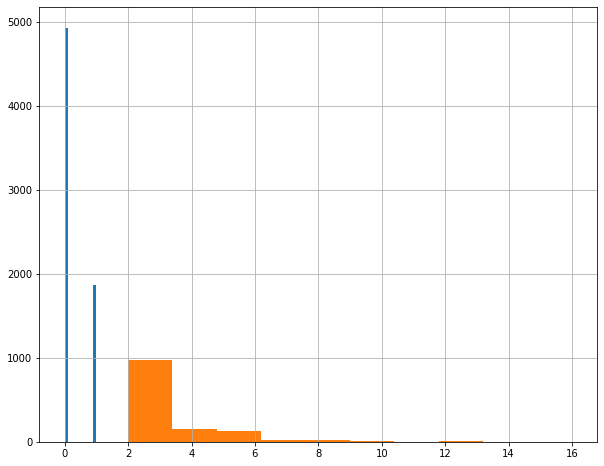

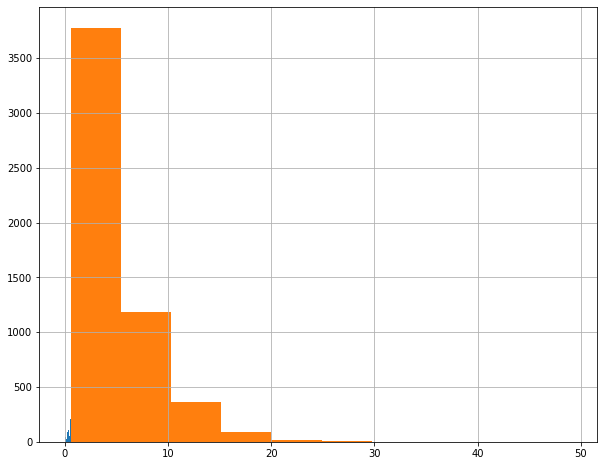

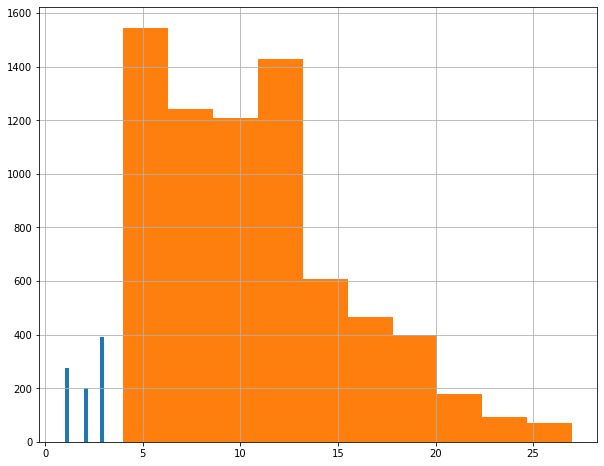

In [76]:
for col, val in zip(futures, [800, 20, 1, None, None, 0.6, 3]):
    if val == None:
        continue
    plt.figure(figsize=(10,8))
    x = df[df[col] <= val][col]
    y = df[df[col] > val][col]

    x.hist()
    y.hist()

    u1, p = mannwhitneyu(x, y, alternative='less', use_continuity=False)
    print(col, 1.0 - p, u1)

In [17]:
# Рассчет эксцесса и ассиметрии
for col in futures:

    new_set = df[[col]]
    v = [0] * 10
    for i in range(len(new_set[col])):
        if i in new_set[col]:
            if int(new_set[col][i] * 10 // 2) > 9:
                continue
            v[int(new_set[col][i] * 10 // 2)] += 1
    
#     print('x * n')
    xn = []
    for i in range(len(v)):
        xn.append((0.1 + i * 0.2) * v[i])
    xv = sum(xn) / sum(v) # выборочная средняя
#     print(sum(v))
    cm2s = [] # центральный момент 2 порядка
    cm3s = [] # центральный момент 3 порядка
    cm4s = [] # центральный момент 4 порядка
    for i in range(len(v)):
        cm2s.append((0.1 + i * 0.2 - xv) ** 2 * v[i])
        cm3s.append(((0.1 + i * 0.2 - xv) ** 3 * v[i]))
        cm4s.append(((0.1 + i * 0.2 - xv) ** 4 * v[i]))
#     print(sum(cm2s))
#     print(sum(cm3s))
#     print(sum(cm4s))
    disp = new_set[col].var() # выборочная дисперсия
#     print(disp)
    delt = disp ** 0.5 # нормальное отклонение
#     print(delt)
    cm3 = sum(cm3s) / sum(v) 
#     print(cm3)
    cm4 = sum(cm4s) / sum(v) 
#     print(cm4)
    print(f"{col}: ")
    print("A =", str(cm3 / delt ** 3))
    print("E =", str(cm4 / delt ** 4))

text_am: 
A = 7.848168122073097e-11
E = 1.027324355082657e-13
n_img: 
A = 2.106140465521553e-05
E = 1.1289713353608714e-06
n_vid: 
A = 0.040964830177422445
E = 0.02809140862737339
created: 
A = 0.9288554773712707
E = 1.8720700040886735
cont: 
A = -0.04904911383189116
E = 1.0494335946480915
mgp: 
A = 0.0030656106931932128
E = 0.001270277809131886
n_pled_t: 
A = 0.0
E = 0.0


In [18]:
# Linear models
import pandas as pd
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import accuracy_score, roc_auc_score, mean_squared_error
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_validate, train_test_split
import numpy as np

In [19]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']
columns = numeric_columns + binary_columns

In [20]:
def test_mse(model, X, y):
    preds = model.predict(X)
    mse = mean_squared_error(y, preds)
    
    return mse

In [21]:
train_X, test_X, train_y, test_y = train_test_split(df[columns], df[target_column], train_size=0.8)

In [22]:
scaler = StandardScaler()

train_data = scaler.fit_transform(train_X)
test_x_data = scaler.transform(test_X)
test_y_data = test_y

In [24]:
# Simple Linear Regression
model = LinearRegression()
model.fit(train_data, train_y)

test_mse(model, train_data, train_y), test_mse(model, test_x_data, test_y_data), model.coef_

(365104.54351689696,
 1887443.7135427212,
 array([ -5.17478476,  -2.1334703 , -38.10091495,  30.02374566,
         -0.81951212,   7.28888135,  -8.64017187, -18.76675176,
         13.96318887,  19.85400555,   2.12254223,   7.03349684,
         45.99746668,   7.76557712,  20.04270283,  24.56123674,
         -0.93446129,  -9.34559132, -11.88127464,  22.36083964,
         -4.33668814,   1.09126681,  12.52791607,  -4.08795991,
          4.81822429,  -6.57786127,  17.82581391,   6.78483722,
         14.51047165]))

In [25]:
# Testing regression /w L1 regularization
lasso = Lasso()
lasso.fit(train_data, train_y)

test_mse(lasso, train_data, train_y), test_mse(lasso, test_x_data, test_y_data), lasso.coef_

(365164.43865517736,
 1887013.3477456754,
 array([ -4.77354964,  -1.30987213, -29.17050202,  29.13159958,
         -0.94518424,   2.76959577,  -8.8197293 ,  -8.75256557,
          5.01274744,  19.78998507,   1.12375993,   6.54560494,
         37.40150911,   6.4467313 ,  18.64268972,  23.65627668,
         -0.27172961,  -8.71074876, -11.01667785,  20.98936821,
         -3.83937084,   0.        ,  11.36548309,  -3.47587381,
          3.62574201,  -5.80893423,  16.59628527,   5.85762519,
         13.3287138 ]))

In [26]:
# Testing regression /w L2 regularization
ridge = Ridge()
ridge.fit(train_data, train_y)

test_mse(ridge, train_data, train_y), test_mse(ridge, test_x_data, test_y_data), ridge.coef_

(365104.5444801243,
 1887441.4505875397,
 array([ -5.17480339,  -2.13787179, -38.04222771,  30.02006927,
         -0.82257492,   7.27687211,  -8.64482346, -18.73465097,
         13.94017647,  19.85175539,   2.12261744,   7.03400279,
         45.94456294,   7.76455405,  20.03888741,  24.55649867,
         -0.93540702,  -9.34457178, -11.8792383 ,  22.35644383,
         -4.33636083,   1.09018324,  12.52565862,  -4.08722602,
          4.81656826,  -6.57759618,  17.8227309 ,   6.78362983,
         14.50818669]))

In [27]:
elastic = ElasticNet()
elastic.fit(train_data, train_y)

test_mse(elastic, train_data, train_y), test_mse(elastic, test_x_data, test_y_data), elastic.coef_

(365927.5456104516,
 1886897.9327719433,
 array([-3.90339685, -0.14123567, -2.203621  , 19.74850842, -0.        ,
         0.81232223, -4.74434725, -4.91925393,  0.        , 14.03977315,
         2.88830883,  6.6055021 , 12.11832488,  5.99871558, 12.32864787,
        15.80154484, -1.52961553, -5.74491515, -7.04025789, 13.7039861 ,
        -3.74033157, -0.        ,  7.64142205, -2.83826045,  3.71047448,
        -3.84279587, 11.74742555,  5.46945936,  9.41661299]))

In [28]:
# Get mean coeffs for futures
coeffs = np.zeros((29))
rounds = 20
for i in range(20):
    scaler = StandardScaler()

    train_data = scaler.fit_transform(train_X)
    test_x_data = scaler.transform(test_X)
    test_y_data = test_y
    
    model = LinearRegression()
    model.fit(train_data, train_y)
    coeffs += model.coef_
    
    lasso = Lasso()
    lasso.fit(train_data, train_y)
    coeffs += lasso.coef_
    
    ridge = Ridge()
    ridge.fit(train_data, train_y)
    coeffs += ridge.coef_
    
    elastic = ElasticNet()
    elastic.fit(train_data, train_y)
    coeffs += elastic.coef_
    
mean_coeffs = coeffs / (rounds * 4)
{k: v for k, v in sorted([(k, v) for k, v in zip(columns, mean_coeffs)], key=lambda x: abs(x[1]), reverse=True)}

{'action': -5.701796887901367,
 'adventure': 6.223887899022584,
 'arcade': 0.5453625109647771,
 'backed': 2.064307107077143,
 'cont': 6.993894514745591,
 'cr_time': 18.383879791397053,
 'created': 6.804651670209101,
 'fighting': -8.286456753977788,
 'goal': -4.7566336620301435,
 'horror': 19.852659445174993,
 'indie': 4.24275225908166,
 'is_site': 12.940996282622947,
 'max_pled_t': -7.712267970851292,
 'mean_pled_t': -12.793305555744045,
 'mgp': 35.36546590154004,
 'min_pled_t': 4.5369178653629945,
 'mmo': -3.6223300471547417,
 'n_img': -26.879316420022338,
 'n_pled_t': -0.64681782088522,
 'n_vid': 27.23098073296551,
 'platformer': 22.143889233787856,
 'quest': 15.998063906512689,
 'rpg': 17.76323195807265,
 'shooter': -0.917803366011688,
 'simulator': 11.015119955395326,
 'step_pled_t': 8.229028194077065,
 'strategy': -4.0631878447543475,
 'survival': -10.454362170214539,
 'text_am': -1.43061247061452}

In [29]:
# Neural network
import numpy as np
import pandas as pd
import torch
from torch import nn
import torch.nn.functional as F
from torch.optim import Adam
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

In [30]:
def get_type(rate):
    type_ = 0
    for i in np.linspace(0, 175, 8):
        if rate < i + 25:
            return type_
        type_ += 1
    return 8

In [44]:
# Add success type

types = []

for idx, row in df.iterrows():
    types.append(get_type(row[-1]))

types = pd.Series(types, dtype=int)
df = df.assign(succes_type=types.values)
print(df[['success_rate', 'succes_type']].head(20))
if 'success_rate' in df.columns:
    df = df.drop(columns='success_rate')
if 'success' in df.columns:
    df = df.drop(columns='success')

    success_rate  succes_type
0       0.100012            0
1    1714.220076            8
2       3.460000            0
3       0.010000            0
4       8.082090            0
5     254.160000            8
6     104.620000            4
7      11.800000            0
8       8.257500            0
9       0.020000            0
10      1.101250            0
11      0.000000            0
12     22.448000            0
13      3.400000            0
14      0.157083            0
15    100.200000            4
16    132.800022            5
17      1.236000            0
18      0.950000            0
19    229.933333            8


In [61]:
df.columns

Index(['Unnamed: 0', 'URL', 'pled', 'goal', 'date', 'period', 'status',
       'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t',
       'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'site',
       'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror',
       'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest',
       'adventure', 'mgp', 'cont', 'curr', 'succsess', 'is_site',
       'succes_type'],
      dtype='object')

In [62]:
df.head(20)

,Unnamed: 0,URL,pled,goal,date,period,status,text_am,n_img,n_vid,n_pled_t,min_pled_t,max_pled_t,mean_pled_t,step_pled_t,cr_time,backed,created,site,rpg,platformer,shooter,fighting,survival,horror,strategy,arcade,simulator,mmo,indie,action,quest,adventure,mgp,cont,curr,succsess,is_site,succes_type
0,8438,https://www.kickstarter.com/projects/577038691...,16.37,16368.00,2013-12-01,14,ended,355,7,0,8,1.64,8184.00,1206.321250,1168.908571,16,0,0,,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0.653856,0.276952,GBP,0,0,0
1,3182,https://www.kickstarter.com/projects/200047954...,124761.28,7278.02,2015-08-03,30,ended,2218,33,3,5,3.64,99.71,43.960000,24.017500,592,3,1,blackwake.com,0,0,1,0,0,0,1,0,0,0,0,1,0,0,6.105621,0.220415,AUD,1,1,8
2,7977,https://www.kickstarter.com/projects/85660245/...,1211.00,35000.00,2013-04-12,31,ended,3174,19,3,13,5.00,1000.00,312.692308,82.916667,253,2,0,swiftcreekgames.com,0,0,0,0,0,0,0,0,0,0,1,0,0,0,2.556285,0.289384,USD,0,1,0
3,1270,https://www.kickstarter.com/projects/193393221...,1.00,10000.00,2013-11-13,14,ended,110,0,0,3,25.00,1000.00,425.000000,487.500000,195,0,0,hobbisoft.com,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,USD,0,1,0
4,6312,https://www.kickstarter.com/projects/148102341...,5415.00,67000.00,2016-04-25,30,ended,3955,46,1,15,1.00,1000.00,165.866667,71.357143,20,3,0,stellartactics.com,1,0,0,1,0,0,1,0,0,0,0,1,0,1,5.987628,0.256332,USD,0,1,0
5,3483,https://www.kickstarter.com/projects/socalmike...,50832.00,20000.00,2014-10-18,30,ended,1124,34,1,23,1.00,1500.00,269.217391,68.136364,880,13,1,readretro.com,0,0,0,0,0,0,0,0,0,0,1,0,0,0,12.843284,0.329026,USD,1,1,8
6,3626,https://www.kickstarter.com/projects/660810230...,10462.00,10000.00,2014-07-14,27,ended,1539,13,1,12,1.00,350.00,61.833333,31.727273,819,20,1,firewithfiregame.com,0,0,0,0,0,0,1,0,0,0,1,1,0,0,4.930404,0.303179,USD,1,1,4
7,2123,https://www.kickstarter.com/projects/906470271...,590.00,5000.00,2016-04-18,30,ended,968,5,0,5,5.00,100.00,51.000000,23.750000,4,11,0,smashthegamestate.com,1,0,1,0,1,0,0,1,1,0,1,0,0,0,1.264800,0.376759,USD,0,1,0
8,6577,https://www.kickstarter.com/projects/projectmo...,3303.00,40000.00,2016-02-27,35,ended,2555,63,1,12,15.00,5000.00,625.000000,453.181818,36,0,0,lobotomycorp.kr,0,0,0,0,0,0,0,0,0,0,1,1,1,0,11.336250,0.325476,USD,0,1,0
9,242,https://www.kickstarter.com/projects/118901985...,2.00,10000.00,2016-03-23,60,ended,113,0,0,2,1.00,20.00,10.500000,19.000000,11,0,0,cugleague.com,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.000000,0.000000,USD,0,1,0


In [52]:
numeric_columns = [
#   'pled',
  'goal',
#   'period',
  'text_am',
  'n_img',
  'n_vid',
  'n_pled_t',
  'min_pled_t',
  'max_pled_t',
  'mean_pled_t',
  'step_pled_t',
  'cr_time',
  'backed',
  'created',
  'mgp',
  'cont']
binary_columns = ['rpg',
  'platformer',
  'shooter',
  'fighting',
  'survival',
  'horror',
  'strategy',
  'arcade',
  'simulator',
  'mmo',
  'indie',
  'action',
  'quest',
  'adventure',
  'is_site']

numeric_data = numeric_columns + binary_columns
target_col = df.corr().columns[-1]

print(numeric_data, target_col)

dataset = df[numeric_data]
target = df[target_col]

['goal', 'text_am', 'n_img', 'n_vid', 'n_pled_t', 'min_pled_t', 'max_pled_t', 'mean_pled_t', 'step_pled_t', 'cr_time', 'backed', 'created', 'mgp', 'cont', 'rpg', 'platformer', 'shooter', 'fighting', 'survival', 'horror', 'strategy', 'arcade', 'simulator', 'mmo', 'indie', 'action', 'quest', 'adventure', 'is_site'] succes_type


In [53]:
model = nn.Sequential(
    nn.BatchNorm1d(28),
    nn.Linear(28, 24),
    nn.ReLU(),
    nn.BatchNorm1d(24),
    nn.Linear(24, 20),
    nn.ReLU(),
    nn.BatchNorm1d(20),
    nn.Linear(20, 10))

optimizer = Adam(model.parameters())
loss_fn = F.cross_entropy

In [54]:
class MyDataset:
    def __init__(self, df):
        self.df = pd.DataFrame(data=df)
    
    def __len__(self):
        return self.df.shape[0]
    
    def __getitem__(self, i):
        return torch.Tensor(self.df.iloc[i])[:-1], torch.Tensor(self.df.iloc[i])[-1].to(torch.long)

In [55]:
from torch.utils.data import DataLoader


train, test = train_test_split(dataset, train_size=0.8)

train_loader = DataLoader(MyDataset(train), batch_size=24, shuffle=True)
test_loader = DataLoader(MyDataset(test), batch_size=24)

In [56]:
model.train()

losses = []
accuracies = []

for epochs in tqdm(range(10)):
    epoch_losses = []
    epoch_accuracies = []
    for xb, yb in tqdm(train_loader):
        accuracy = 0
        correct_answers = 0
        
        optimizer.zero_grad()

        outp = model(xb)
        loss = loss_fn(outp, yb)

        loss.backward()
        optimizer.step()
        
        epoch_losses.append(loss.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        epoch_accuracies.append(accuracy)
    
    losses.append(torch.tensor(epoch_losses).mean())
    accuracies.append(torch.tensor(epoch_accuracies).mean())
    
    print('loss:', losses[-1])
    print('accuracy: ', accuracies[-1])

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(1.6453)
accuracy:  tensor(0.5458)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.6371)
accuracy:  tensor(0.7325)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5436)
accuracy:  tensor(0.7374)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5270)
accuracy:  tensor(0.7383)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5205)
accuracy:  tensor(0.7397)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5178)
accuracy:  tensor(0.7409)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5138)
accuracy:  tensor(0.7454)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5143)
accuracy:  tensor(0.7455)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5149)
accuracy:  tensor(0.7445)


  0%|          | 0/271 [00:00<?, ?it/s]

loss: tensor(0.5078)
accuracy:  tensor(0.7518)


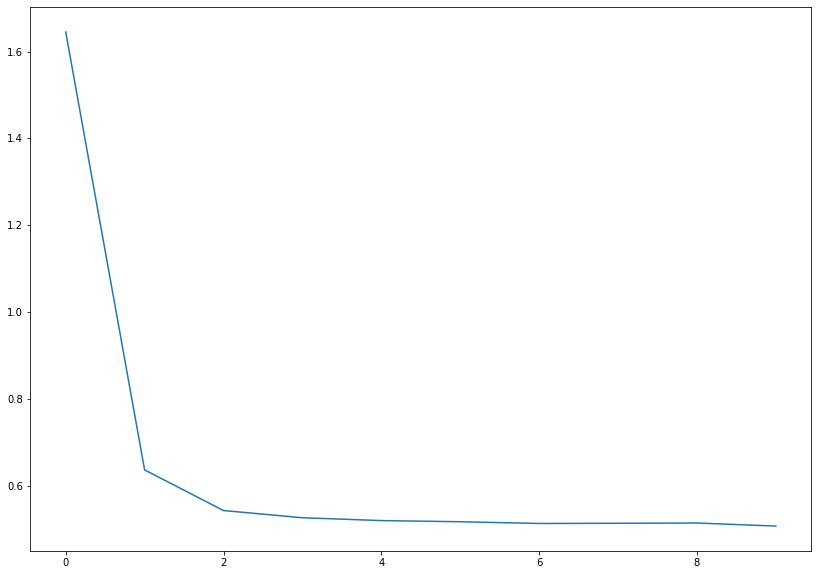

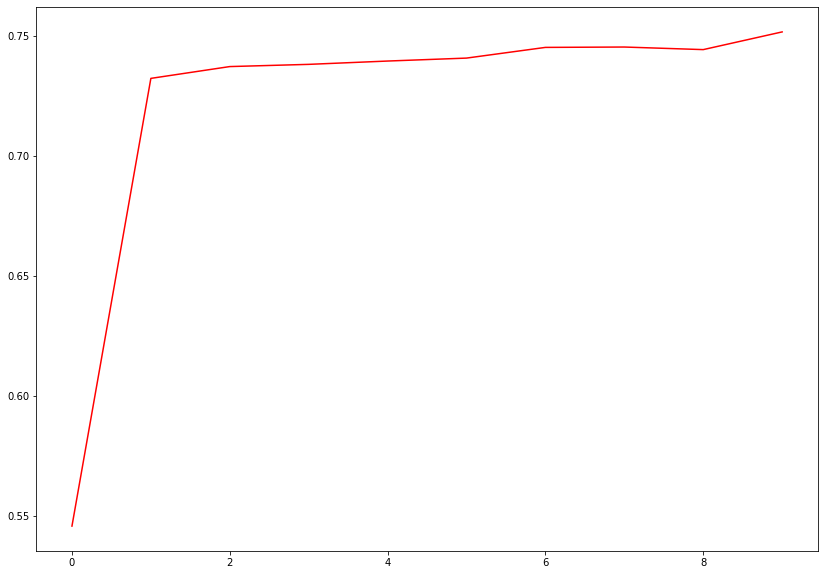

In [57]:
plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), losses, label='loss')

plt.figure(figsize=(14, 10))
plt.plot(range(epochs + 1), accuracies, label='accuracy', c='r')

In [58]:
model.eval()

preds = []
real = []

losses = []
accuracies = []

for xb, yb in test_loader:
    with torch.no_grad():
        outp = model(xb)
        for val in outp.argmax(-1):
            preds.append(val.item())
        for val in yb:
            real.append(val.item())
        
        correct_answers = (outp.argmax(-1) == yb).sum()
        accuracy = correct_answers / xb.shape[0]
        accuracies.append(accuracy)
torch.Tensor(accuracies).mean()

tensor(0.7281)

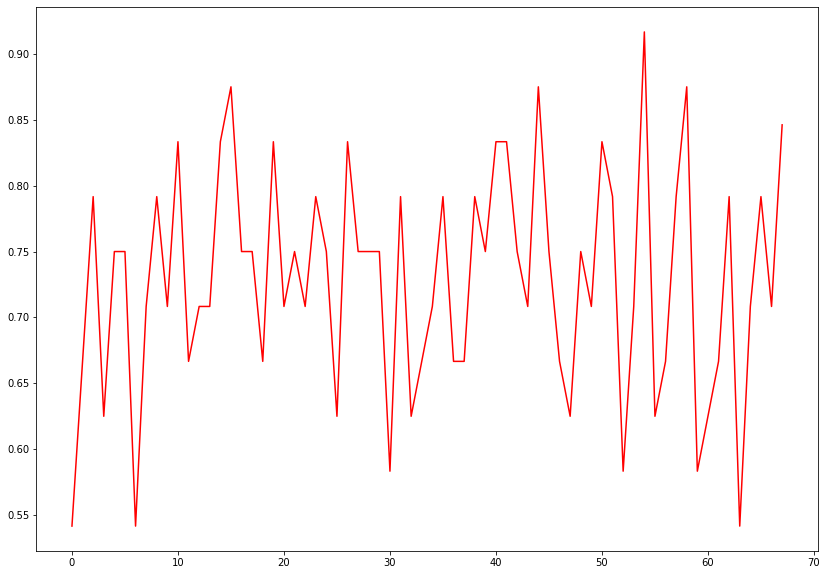

In [59]:
plt.figure(figsize=(14, 10))
plt.plot(np.arange(len(test_loader)), accuracies, label='accuracy', c='r')

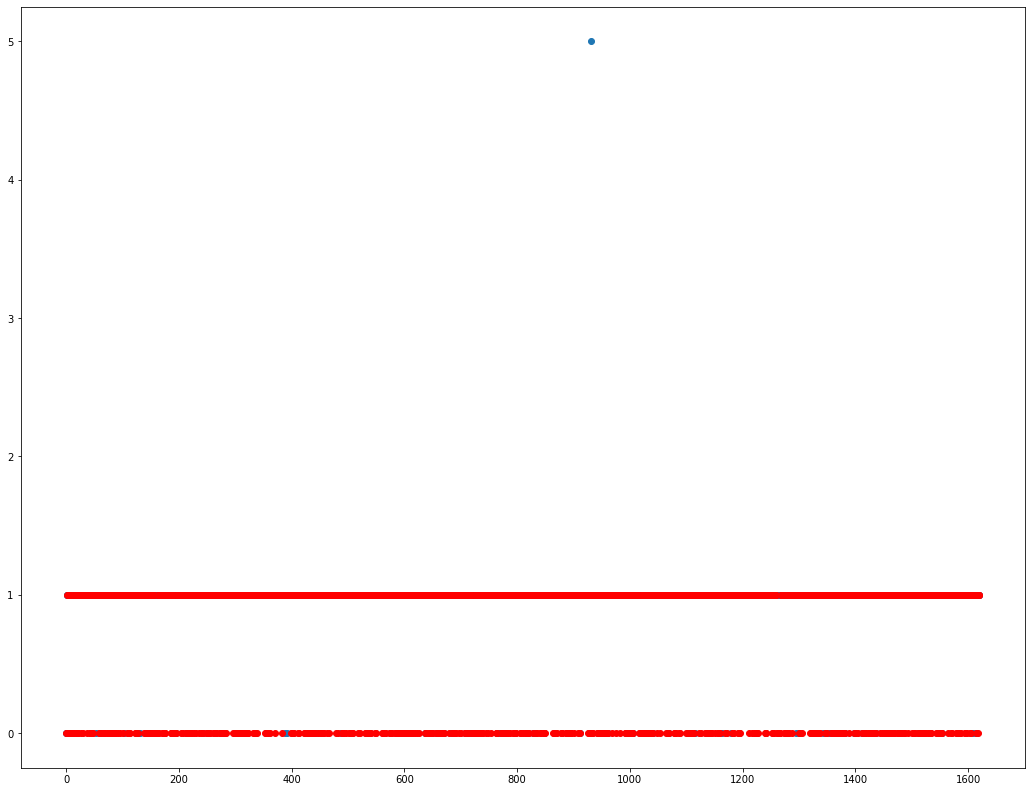

In [60]:
plt.figure(figsize=(18, 14))
plt.scatter(np.arange(len(preds)), preds)
plt.scatter(np.arange(len(real)), real, c='red')